# Visualization -EigenCam (in progress)
**Author**: Hyeri

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Input 
import cv2

def img_to_tensor(img_path, img_size=(100,100,3), RGB=True):
    img = cv2.imread(img_path, 1)[...,::-1]
    img_tensor = cv2.resize(img, img_size[:2])
    img_tensor = np.float32(img_tensor) / 255 if RGB else img_tensor
    return np.float32(img_tensor)

def pp_result(cam, img_tensor, result):
    _, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].set_title(result)
    axs[0].imshow(img_tensor)
    axs[0].imshow(cam, alpha=0.7)
    cam_adj = show_cam_on_image(img_tensor, cam)
    plt.title(result + ' (adjusted)')
    axs[1].imshow(cam_adj)
    plt.show()

In [2]:
labels_raf = {  0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }
labels_fer = {  0:  'NF',
                1:  'anger',
                2:  'comtempt',
                3:  'disgust',
                4:  'fear',
                5:  'happiness',
                6:  'neutral',
                7:  'sadness',
                8:  'surprise',
                9:  'unknown'
            }

## Path

In [3]:
model_fer = './models/model_ferplus_h.h5'
model_raf = './models/model_raf_h.h5'
input_model = model_raf

# 5, 6, 7, 10, 11, 13, 14, 16, 19, 22, 26
# fer ; 7(anger), 8(surprise-wrong), 12(happy), 13(happy), 17(neutral - wrong), 19(happy), 21(komisch), 24(neutral), 25(happy), 37(neutral-wrong), 40(horror..),
#       41(happy), 45(sad), 69(sad)
# raf ; 9(happy), 14(happy), 15(surprise), 17(disgust-wrong), 21(happy), 24(neutral), 37(anger), 39(sad), 48(happy), 283(disgust), 623(fear), 1788(fear)
img_path = './data/RAF/images/test_0014_aligned.jpg'

## Image

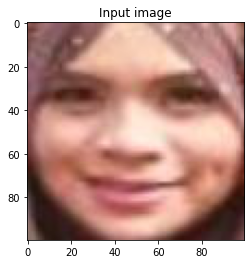

In [4]:
img_size = (100,100,3)
img_tensor = img_to_tensor(img_path, img_size)
plt.title('Input image')
plt.imshow(img_tensor)

input_img_tensor = img_tensor[np.newaxis, ...]

## Model

In [5]:
# Emotion label for RAF-DB
emotions = {    0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }

model = load_model(input_model)
#print([layer.name for layer in model.layers])

# Activation model : ~ last conv layer
last_conv_layer_name = 'conv2d_7'
last_conv_layer = model.get_layer(last_conv_layer_name)
activation_model = tf.keras.Model(model.inputs, last_conv_layer.output)

classification_result = np.argmax(model.predict(input_img_tensor)[0])
activation = activation_model.predict(input_img_tensor)                   # shape (1, 11, 11, 128)
#print(activation.shape)

2022-01-24 08:30:11.692496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-24 08:30:11.692586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-01-24 08:30:11.941443: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-24 08:30:11.994511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 08:30:12.103266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## EigenCam

In [6]:
def get_class_activation_map(activations):
    reshaped_activations = activations.reshape(activations.shape[3], -1).transpose()
    reshaped_activations -= reshaped_activations.mean(axis=0)
    _, _, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
    projection = [activations[:,:,:,i] * VT[0,i] for i in range(activations.shape[3])]
    cam = np.zeros(shape = (11,11))
    for filters in projection:
        cam += filters[0]
    return np.float32(cam)

def scale_cam_image(img, target_size=(100,100)):
    img = img - np.min(img)
    img = img / (1e-7 + np.max(img))
    img = cv2.resize(img, target_size)
    result = np.float32(img)
    return result

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")
    cam = 0.7 * heatmap + img
    cam /= np.max(cam)
    return np.uint8(255 * cam)

## Visualization

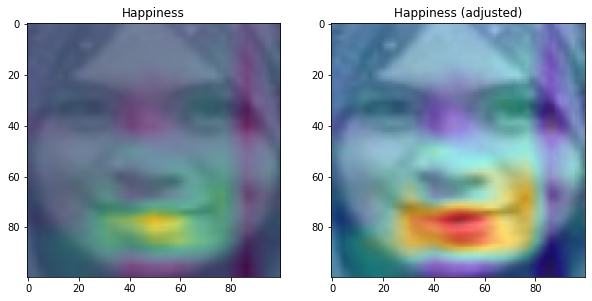

In [7]:
cam = get_class_activation_map(activation)
result = labels_raf[classification_result] if input_model==model_raf else labels_fer[classification_result]
pp_result(scale_cam_image(cam), img_tensor, result)